In [12]:
import sys, os, time, datetime,pickle
from tqdm import tqdm

import pandas as pd
import numpy as np

from sklearn.preprocessing import OneHotEncoder

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init

import matplotlib.pyplot as plt

import multiprocessing as mp
from multiprocessing import  Pool
num_cores = mp.cpu_count()
print('# of Cores: {}'.format(num_cores))

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

dataset_path = "../datasets/avazu"

# of Cores: 12
cuda:0


___

In [13]:
CHUNKSIZE = 1000000

# Read input and output path
data_path = dataset_path + '/raw/train'

#fields = ['click','C1','C15','C16','C18','site_category','app_category','device_type','device_conn_type']
fields = ['click',  'C1', 'banner_pos', 'site_id', 'site_domain',
       'site_category', 'app_id', 'app_domain', 'app_category', 'device_model', 'device_type', 'device_conn_type', 'C14',
       'C15', 'C16', 'C17', 'C18', 'C19', 'C20', 'C21']

# Read 'Massive' dataset
print('Start reading')
df_chunks = []
with tqdm(desc='# of Rows Read: ', unit=' Rows') as pbar:
    for chunk in pd.read_csv(data_path, chunksize=CHUNKSIZE, usecols=fields):
        df_chunks.append(chunk)
        pbar.update(len(chunk.index))
        
print('Reading was finished')

Start reading


# of Rows Read: : 40428967 Rows [01:04, 630845.35 Rows/s]

Reading was finished


In [14]:
from functools import partial

def func(df, column):
    return df[column].value_counts(ascending=True)

def get_proportion(df_chunks, column, n_cores=num_cores):
    
    num_list = []
    for chunk in df_chunks:
        num_list.append(func(chunk, column))
        
    dummy = pd.DataFrame(pd.concat(num_list),columns=[column])
    
    aa = dummy.groupby(dummy.index)[column].sum()
    
    aa = aa.div(aa.sum())
    
    return aa

In [15]:
thres_prop = 0.01

_df_chunks = df_chunks
for column in fields:

    if column != 'click':
    
        prop = get_proportion(_df_chunks,column)
        bad_idxs = list(prop[prop < thres_prop].index)
        #print(prop)
        #print(bad_idxs)

        dummy_list = []
        L = 0
        for chunk in _df_chunks:
            new_chunk = chunk.loc[~chunk[column].isin(bad_idxs)]
            dummy_list.append(new_chunk)
            L += len(new_chunk)
            
        print(column,L)
        _df_chunks = dummy_list

C1 40264901
banner_pos 40200488
site_id 27460928
site_domain 27460928
site_category 27460928
app_id 20753940
app_domain 20753940
app_category 20753940
device_model 9532800
device_type 9532800
device_conn_type 9532800
C14 4847967
C15 4847967
C16 4847967
C17 4847967
C18 4847967
C19 4807950
C20 4720285
C21 4720285


In [16]:
sample_ratio = 1/4.720285

aggr_list = []
for chunk in _df_chunks:
    aggr_list.append(chunk.sample(frac=sample_ratio))
    
df_target = pd.concat(aggr_list).reset_index(drop=True)

In [17]:
print(len(df_target))
df_target.head()

1000001


,click,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,app_category,device_model,device_type,device_conn_type,C14,C15,C16,C17,C18,C19,C20,C21
0,0,1005,1,5b4d2eda,16a36ef3,f028772b,ecad2386,7801e8d9,07d7df22,d4897fef,1,0,19950,320,50,1800,3,167,-1,23
1,0,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,07d7df22,1f0bc64f,1,0,15701,320,50,1722,0,35,-1,79
2,1,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,07d7df22,711ee120,1,0,15702,320,50,1722,0,35,-1,79
3,0,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,07d7df22,c6263d8a,1,0,15703,320,50,1722,0,35,-1,79
4,0,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,07d7df22,36d749e5,1,0,15701,320,50,1722,0,35,-1,79


In [18]:
from sklearn import preprocessing

feature_list = []
for column in fields:
    if column != 'click':
        print(column)
        encoding = preprocessing.LabelBinarizer()
        feature_list.append(encoding.fit_transform(df_target[column]))
        
features = np.concatenate(feature_list, axis=1)

C1
banner_pos
site_id
site_domain
site_category
app_id
app_domain
app_category
device_model
device_type
device_conn_type
C14
C15
C16
C17
C18
C19
C20
C21


In [19]:
features = np.concatenate(feature_list, axis=1)
features.shape

(1000001, 124)

In [20]:
reward = np.asarray(df_target['click'])
reward.shape

(1000001,)

In [21]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, average_precision_score

X_train = features
Y_train = reward


clf = LogisticRegression(random_state=9999, max_iter=3000, tol=1e-3).fit(X_train, Y_train)

prob_estimate_train = clf.predict_proba(X_train)

train_auroc = roc_auc_score(Y_train, prob_estimate_train[:, 1])
train_auprc = average_precision_score(Y_train, prob_estimate_train[:, 1])

print("Train AUROC : {:.6f}".format(train_auroc))
print("Train AUPRC : {:.6f}".format(train_auprc))

Train AUROC : 0.728098
Train AUPRC : 0.302032


In [22]:
tail = '_mili'

reward0_idx = np.where(reward == 0)[0]
reward1_idx = np.where(reward == 1)[0]

len(reward0_idx) + len(reward1_idx)

1000001

In [23]:
np.save(dataset_path + '/preprocess/X0{}'.format(tail),features[reward0_idx,:])
np.save(dataset_path + '/preprocess/X1{}'.format(tail),features[reward1_idx,:])

____

## Training Autoencoder

In [24]:
# Hyperparameters for Training
'''
learning_rate = 0.00005
weight_decay  = 0.00001
num_epoch = 300 #Normally 100
B = 25000 # batchsize

BN = True
EMB_DIM = 32
'''

learning_rate = 0.00001
weight_decay  = 0.000001
num_epoch = 800 #Normally 100
B = 10000 # batchsize

EMB_DIM = 32

# Additional char tail for save/load
load_tail = '_mili'
save_tail = '_mili32'

class BN_Autoencoder(nn.Module):
    def __init__(self, d, emb_dim):
        super().__init__()
        self.emb_dim = emb_dim
        self.d = d
        self.encoder = nn.Sequential(nn.Linear(self.d, self.emb_dim),nn.BatchNorm1d(self.emb_dim))
        self.decoder = nn.Linear(self.emb_dim, self.d)
                
    def forward(self, x):
        batch_size = x.shape[0]
        x = x.view(x.shape[0],-1)
        encoded = self.encoder(x)
        out = self.decoder(encoded).view(batch_size, self.d)
        return out
    
    def encoding_result(self, x):
        batch_size = x.shape[0]
        x = x.view(x.shape[0],-1)
        encoded = self.encoder(x)
        return encoded

In [25]:
X = np.vstack([np.load(dataset_path+'/preprocess/X0{}.npy'.format(load_tail)),np.load(dataset_path+'/preprocess/X1{}.npy'.format(load_tail))])
np.random.shuffle(X)
d = X.shape[1]

model = BN_Autoencoder(d=d, emb_dim=EMB_DIM).to(device)
loss_func = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

In [26]:
L = X.shape[0]

loss_arr = []

for k in tqdm(range(num_epoch)):
    
    for l in range(L//B):
        
        batch  = X[l*B:(l+1)*B, :].copy()
        
        x = torch.from_numpy(batch).type(torch.FloatTensor).to(device)

        optimizer.zero_grad()
        output = model.forward(x)
        loss = loss_func(output,x)
        loss.backward()
        optimizer.step()

    loss_arr.append(loss.cpu().data.numpy())

100%|██████████| 800/800 [05:27<00:00,  2.44it/s]


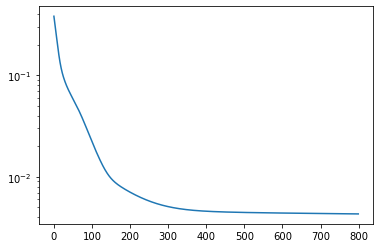

In [27]:
plt.plot(loss_arr)
plt.yscale("log")

In [28]:
torch.save(model.state_dict(), '../models/avazu_autoencoder{}.pt'.format(save_tail))